# Fake News Detection


Fake news detection is a process that involves analyzing news content to determine its truthfulness. It is a subtask of text classification, and is defined as the task of classifying news as real or fake.

About the Dataset:
1. title, the title of a news article
2. text, the text of the article
3. subject, the category of a news article
4. date, the publication date of an article

# Import all required libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
from datetime import datetime

import re  # regular expression lib
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer  # strip words of prefix and postfix
from sklearn.feature_extraction.text import TfidfVectorizer  # convert text into value features
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score



In [25]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Examples of stopwords in English

In [27]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

# Load input data

In [ ]:
#with ZipFile('/content/drive/MyDrive/Courses/kaggle/Fake news detection (NLP)/input_data/fake.csv.zip', 'r') as fake:
#    fake.extractall('/content/drive/MyDrive/Courses/kaggle/Fake news detection (NLP)/input_data/')

In [ ]:
#with ZipFile('/content/drive/MyDrive/Courses/kaggle/Fake news detection (NLP)/input_data/true.csv.zip', 'r') as true:
#    true.extractall('/content/drive/MyDrive/Courses/kaggle/Fake news detection (NLP)/input_data/')

In [84]:
fake_news = pd.read_csv('/content/drive/MyDrive/Courses/kaggle/Fake news detection (NLP)/input_data/fake.csv')
true_news = pd.read_csv('/content/drive/MyDrive/Courses/kaggle/Fake news detection (NLP)/input_data/true.csv')

In [60]:
fake_news.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [61]:
true_news.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


Merge all news in solid dataframe with "target" column:
* 1 - Fake news
* 0 - True news

In [85]:
def combine_data(true_data, false_data):
    true_data['target'] = 0
    false_data['target'] = 1
    all_data = pd.concat([true_data, false_data])

    print("True shape: ", true_data.shape)
    print("False shape: ", false_data.shape)
    print("All data shape: ", all_data.shape)

    return all_data.sample(frac=1).reset_index(drop=True)

In [86]:
all_news = combine_data(true_news, fake_news)

True shape:  (21417, 5)
False shape:  (23481, 5)
All data shape:  (44898, 5)


# Exploration

The amount of missed values.

In [64]:
all_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   target   44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [65]:
all_news.isnull().sum()

title      0
text       0
subject    0
date       0
target     0
dtype: int64

News distribution True : Fake

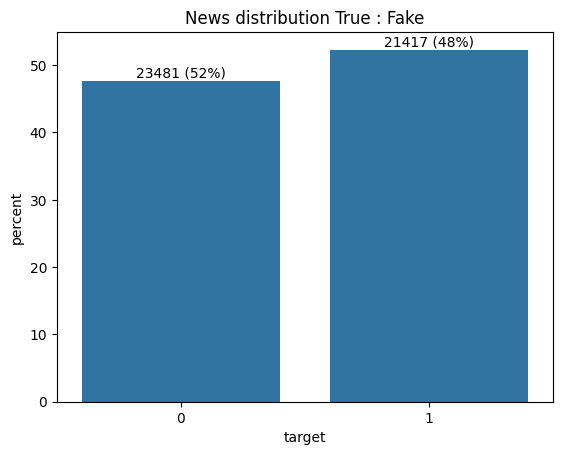

In [66]:
ax = sns.countplot(x=all_news["target"], stat='percent')

abs_values = all_news['target'].value_counts()
rel_values = all_news['target'].value_counts(normalize=True).values * 100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)
plt.title('News distribution True : Fake')
plt.show()

Date distribution based on Subject.

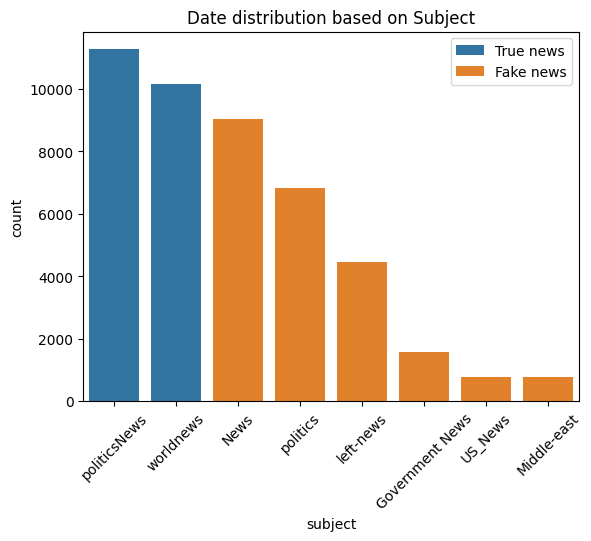

In [67]:
sns.countplot(data=all_news, x='subject', order=all_news['subject'].value_counts(ascending=False).index, hue='target')
plt.xticks(rotation=45)
plt.title('Date distribution based on Subject')
plt.legend(["True news", "Fake news"])
plt.show()

Explore the time interval.

Some records contain link instead of date in this feature, so it is better to get rid of them. Mostly date contains no more than 19 characters, so others can be elliminated.

In [98]:
index_to_drop = list()
for index, rec in zip(all_news['date'].sort_values().index, all_news['date'].sort_values().values):
    if len(rec) > 20:
        index_to_drop.append(index)
        print(rec, len(rec))

MSNBC HOST Rudely Assumes Steel Worker Would Never Let His Son Follow in His Footsteps…He Couldn’t Be More Wrong [Video] 120
https://100percentfedup.com/12-yr-old-black-conservative-whose-video-to-obama-went-viral-do-you-really-love-america-receives-death-threats-from-left/ 149
https://100percentfedup.com/served-roy-moore-vietnamletter-veteran-sets-record-straight-honorable-decent-respectable-patriotic-commander-soldier/ 145
https://100percentfedup.com/video-hillary-asked-about-trump-i-just-want-to-eat-some-pie/ 88
https://fedup.wpengine.com/wp-content/uploads/2015/04/entitled.jpg 66
https://fedup.wpengine.com/wp-content/uploads/2015/04/entitled.jpg 66
https://fedup.wpengine.com/wp-content/uploads/2015/04/entitled.jpg 66
https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg 74
https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg 74
https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg 74


In [100]:
all_news.loc[index_to_drop, 'date'] = np.NaN

In [104]:
pd.to_datetime(all_news.date).describe()

<ipython-input-104-4c8cca37de7e>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  pd.to_datetime(all_news.date).describe()


count                   44888
unique                   1010
top       2017-12-20 00:00:00
freq                      197
first     2015-03-31 00:00:00
last      2018-02-19 00:00:00
Name: date, dtype: object

So this dataframe contains records between 2015-03-31 and 2018-02-19.

# Proccessing

To use data for modeling it is required to create a single line for each row.

In [111]:
all_news['content'] = all_news['subject'] + ' ' + all_news['title'] # TBD (will be added later) + ' ' +	all_news['text']

In [112]:
all_news.head()

,title,text,subject,date,target,content
0,U.N. Security Council to meet Monday on North ...,UNITED NATIONS (Reuters) - The United Nations ...,worldnews,"September 3, 2017",0,worldnews U.N. Security Council to meet Monday...
1,Libyan forces suffer casualties as fighting dr...,"BENGHAZI, Libya (Reuters) - Libyan forces figh...",worldnews,"December 11, 2017",0,worldnews Libyan forces suffer casualties as f...
2,BRILLIANT NIGEL FARAGE On How THE GOP Can Win ...,"Former British lawmaker Nigel Farage, who succ...",politics,"Jul 18, 2016",1,politics BRILLIANT NIGEL FARAGE On How THE GOP...
3,Mattis reaffirms U.S. alliance with Japan 'for...,TOKYO (Reuters) - U.S. Defense Secretary Jim M...,politicsNews,"February 4, 2017",0,politicsNews Mattis reaffirms U.S. alliance wi...
4,Kansas budget woes weigh on state's credit rat...,(Reuters) - Moody’s Investors Service on Tuesd...,politicsNews,"May 3, 2016",0,politicsNews Kansas budget woes weigh on state...


Stem records (Process of reducing a word to its Root word)

In [113]:
port_stem = PorterStemmer()

In [114]:
def stemming(raw_text):
    stemmed_content = re.sub('[^a-zA-Z]', ' ', raw_text)  # substitute everything except alphabetic values
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [115]:
all_news['content_stemmed'] = all_news['content'].apply(stemming)

In [116]:
all_news.head()

,title,text,subject,date,target,content,content_stemmed
0,U.N. Security Council to meet Monday on North ...,UNITED NATIONS (Reuters) - The United Nations ...,worldnews,"September 3, 2017",0,worldnews U.N. Security Council to meet Monday...,worldnew u n secur council meet monday north k...
1,Libyan forces suffer casualties as fighting dr...,"BENGHAZI, Libya (Reuters) - Libyan forces figh...",worldnews,"December 11, 2017",0,worldnews Libyan forces suffer casualties as f...,worldnew libyan forc suffer casualti fight dra...
2,BRILLIANT NIGEL FARAGE On How THE GOP Can Win ...,"Former British lawmaker Nigel Farage, who succ...",politics,"Jul 18, 2016",1,politics BRILLIANT NIGEL FARAGE On How THE GOP...,polit brilliant nigel farag gop win real ameri...
3,Mattis reaffirms U.S. alliance with Japan 'for...,TOKYO (Reuters) - U.S. Defense Secretary Jim M...,politicsNews,"February 4, 2017",0,politicsNews Mattis reaffirms U.S. alliance wi...,politicsnew matti reaffirm u allianc japan yea...
4,Kansas budget woes weigh on state's credit rat...,(Reuters) - Moody’s Investors Service on Tuesd...,politicsNews,"May 3, 2016",0,politicsNews Kansas budget woes weigh on state...,politicsnew kansa budget woe weigh state credi...


Split data and label into separate dataframes.

In [117]:
X, Y = all_news['content_stemmed'], all_news['target']
print(f"X has shape: {X.shape} \nY has shape: {Y.shape}")

X has shape: (44898,) 
Y has shape: (44898,)


Convert text to numeric data

In [118]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X)

X = vectorizer.transform(X)

Split data into train and test.

In [119]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=123, stratify=Y)

# Feature Engineering

In [ ]:
# TBD

# Modeling

Training Logistic Regression model.

In [120]:
model_lr = LogisticRegression()

In [121]:
model_lr.fit(x_train, y_train)

LogisticRegression()

Evaluation

In [122]:
x_train_prediction = model_lr.predict(x_train)
train_accuracy = accuracy_score(y_train, x_train_prediction)

x_test_prediction = model_lr.predict(x_test)
test_accuracy = accuracy_score(y_test, x_test_prediction)

print(f"Accuracy: \n\tTrain: {train_accuracy} \n\tTest: {test_accuracy}")

Accuracy: 
	Train: 0.9999363624793178 
	Test: 0.9999257609502599


# Simple Predictive System

In [135]:
def news_converter(news_value):
  if news_value == 0:
      return 'Real'
  else:
      return 'Fake'

In [137]:
NEWS_ID = 50
sample_to_test = x_test[NEWS_ID]

prediction = model_lr.predict(sample_to_test)
print(f"Originally it was defined as {news_converter(y_test.iloc[NEWS_ID])} and model define it as {news_converter(prediction[0])}")

Originally it was defined as Fake and model define it as Fake


... it will be continued

# EXTRA: Way to select NN configuration

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
INPUT_DIM = X_train.shape[1]

def create_model(layers, activation):
    model = Sequential()
    for i, nodes in enumerate(layers):
        if i==0:
            model.add(Dense(nodes, input_dim=INPUT_DIM))
            model.add(Activation(activation))
        else:
            model.add(Dense(nodes))
            model.add(Activation(activation))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, verbose=0)

In [ ]:
layers = [[20], [40,20], [45,30,15]]
activations = ['sigmoid', 'relu']
param_grid = dict(layers=layers, activation=activations, batch_size=[128, 256], epochs=[30])
grid = GridSearchCV(estimator=model, param_grid=param_grid)

In [ ]:
grid_result = grid.fit(X, Y)

In [ ]:
# SHOW THE RESULT OF TUNING
[grid_result.best_score_, grid_result.best_params_]